In [97]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.tsa.api import VAR
from scipy.linalg import sqrtm, cholesky
from scipy.stats import chi2
from scipy.optimize import root_scalar

/Users/maximecoulet/miniconda3/envs/spiv_replic/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


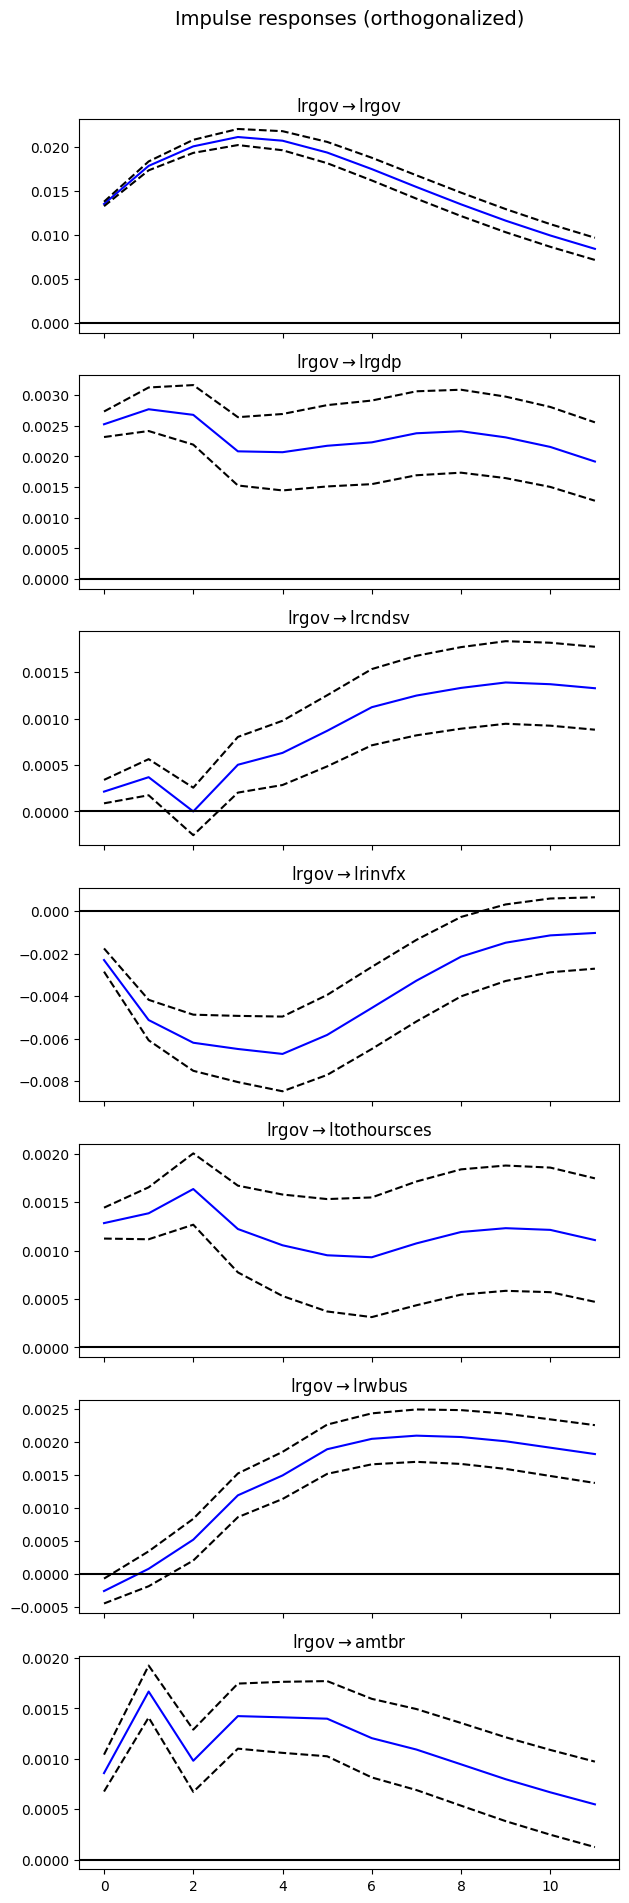

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.935
Model:                            OLS   Adj. R-squared (uncentered):              0.930
Method:                 Least Squares   F-statistic:                              159.2
Date:                Thu, 09 Jan 2025   Prob (F-statistic):                    6.93e-08
Time:                        14:33:43   Log-Likelihood:                          72.207
No. Observations:                  12   AIC:                                     -142.4
Df Residuals:                      11   BIC:                                     -141.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/Users/maximecoulet/miniconda3/envs/spiv_replic/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)


np.float64(64.52964189323156)

In [93]:
## Preprocessing

# Load the data
govdat = pd.read_csv("data/government_spending/govdat3908.csv")

# Remove data before start_time
start_date = datetime(1947,1,1)
govdat = govdat[govdat["quarter"] >= start_date.year]
num_obs = len(govdat)

# Create quarter date index
govdat["qdate"] = pd.date_range(start=start_date, periods=num_obs, freq="QE")
govdat.set_index("qdate", inplace=True)

# Set dtypes
govdat.replace(".", np.nan, inplace=True)
govdat = govdat.astype(float)

# Create linear and quadratic trend
govdat["t"] = govdat["quarter"]
govdat["t2"] = govdat["quarter"]**2

# Create rwbus variable
govdat["rwbus"] = govdat["nwbus"] / govdat["pbus"]

# Create log variables for the variables in the list
varlist = [
    "rgdp",
    "rcons",
    "rcnd",
    "rcsv",
    "rcdur",
    "rcndsv",
    "rinv",
    "rinvfx",
    "rnri",
    "rres",
    "tothours",
    "tothoursces",
    "rgov",
    "rdef",
]

for var in varlist:
    govdat[f"l{var}"] = np.log(govdat[var] / govdat["totpop"])

# Log variables for other variables in the list
varlist2 = ["totpop", "rwbus", "cpi", "pgdp"]
for var in varlist2:
    govdat[f"l{var}"] = np.log(govdat[var])

# Average Ratio GDP to Gov Spending from 1947 to 2008
avg_ratio = govdat["ngdp"].sum() / govdat["ngov"].sum()

## Build the VAR model using the standard identification method

# Select the columns for the model
vars_for_var = [
    "lrgov",
    "lrgdp",
    "lrcndsv",
    "lrinvfx",
    "ltothoursces",
    "lrwbus",
    "amtbr",
]

# Param
horizons = range(12)
H = len(horizons)
num_var = len(vars_for_var)
burn_in = 0
lag_order = 4
num_ins = 1
num_reg = 1
T = num_obs - lag_order - len(horizons) - burn_in - 1

# Create the VAR model
model = VAR(govdat[vars_for_var], exog=govdat[["t", "t2"]])

# Fit the model
var_result = model.fit(lag_order, trend='n')

# Get the impulse response function (IRF)
irf = var_result.irf(max(horizons))

# Plot the IRF for government spending shock
irf.plot(impulse="lrgov", signif = 0.68, orth = True, figsize=(6, 20))
plt.show()

# Regression
target = "lrgdp"
regressor = "lrgov"
instruments = "lrgov"

# Matrix
X = govdat[vars_for_var].to_numpy()
exog = govdat[["t", "t2"]].to_numpy()
X_stacked = np.hstack([X[burn_in + lag:burn_in + T+lag] for lag in range(lag_order)]).T

MX = np.eye(T) - X_stacked.T @ np.linalg.inv(X_stacked @ X_stacked.T) @ X_stacked

Z = X[burn_in + lag_order : burn_in + T + lag_order, vars_for_var.index(instruments)].T

R = np.kron(np.eye(num_reg), np.eye(H).flatten())

X_H = np.hstack([X[lag_order + burn_in + h + 1 : lag_order + T + burn_in + h + 1] for h in horizons]).T
y_H = np.vstack([X_H[h * num_var + vars_for_var.index(target)] for h in horizons])
Y_H = np.vstack([X_H[h * num_var + vars_for_var.index(regressor)] for h in horizons])

# Forecast Matrix
X_H_fcst = np.zeros(X_H.shape)
for t in range(T):
    X_t = X[: burn_in + t + lag_order]
    for h in horizons:
        fcst = var_result.forecast(
            y=X_t,
            exog_future=exog[burn_in + t + lag_order + 1 : burn_in + t + lag_order + 1 + h + 1],
            steps=h + 1,
        )[-1]
        X_H_fcst[h*num_var:(h+1)*num_var, t] = fcst # try to not use var instead estimate yourself with the stacked representation, just a simple OLS even with an exogenous variable just add in X_t

# Error Forecast Matrix
X_H_perp = X_H - X_H_fcst
y_H_perp = np.vstack([X_H_perp[h * num_var + vars_for_var.index(target)] for h in horizons])
Y_H_perp = np.vstack([X_H_perp[h * num_var + vars_for_var.index(regressor)] for h in horizons])

# IRFs
IRFs = irf.orth_irfs
Gov_Spending_IRF = irf.orth_irfs[
    :, vars_for_var.index(regressor), vars_for_var.index(instruments)
]
GDP_IRF = irf.orth_irfs[:, vars_for_var.index(target), vars_for_var.index(instruments)]

# Government Spending Shock
cov_matrix = var_result.sigma_u
resid = var_result.resid.T
P = cholesky(cov_matrix, lower=True)
Shocks = (np.linalg.inv(P) @ resid).to_numpy()
Gov_Spending_Shock = Shocks[vars_for_var.index(instruments)]
Z_perp = Gov_Spending_Shock[burn_in + lag_order +1 : burn_in + T + lag_order + 1].T

# First Stage error SP-IV
Q = (Z_perp @ Z_perp.T)/T
v_H_perp = Y_H_perp - np.sqrt(1 / Q) * Gov_Spending_IRF.reshape(H, num_ins) @ Z_perp.reshape(num_ins, T)

# Second Stage SP-IV
reg = sm.OLS(GDP_IRF, Gov_Spending_IRF, hasconst=False).fit()
print(reg.summary()) # Elsaticity of GDP w.r.t Gov Spending
Gov_Spending_Mult = reg.params[0] * avg_ratio # Gov Spending Multiplier

# Second Stage error SP-IV
ZM = np.sqrt(T / (Z @ MX @ Z.T)) * Z @ MX

def u1(b: np.ndarray) -> np.ndarray:
    return y_H_perp - np.kron(b.T, np.eye(H)) @ Y_H_perp

def u2(b: np.ndarray) -> np.ndarray:
    return (GDP_IRF - np.kron(b.T, np.eye(H)) @ Gov_Spending_IRF).reshape(H, num_ins) @ ZM.reshape(num_ins, T)


# KLM
YP = Gov_Spending_IRF.reshape(H, num_ins) @ ZM.reshape(num_ins, T)

def KLM(b: np.ndarray) -> np.ndarray:
    Sigma_inv = np.linalg.inv((u1(b) - u2(b)) @ u1(b).T)
    Y_tilde = YP - v_H_perp @ (u1(b) - u2(b)).T @ np.linalg.inv(
        (u1(b) - u2(b)) @ (u1(b) - u2(b)).T
    ) @ u2(b)
    term1 = (Sigma_inv @ u1(b) @ Y_tilde.T).flatten().T @ R.T
    term2 = (
        R @ np.kron(Y_tilde @ Y_tilde.T, Sigma_inv @ u1(b) @ u1(b).T @ Sigma_inv) @ R.T
    )
    term3 = R @ (Sigma_inv @ u1(b) @ Y_tilde.T).flatten().T
    return (T - num_var*4 - num_ins) * term1 @ np.linalg.inv(term2) @ term3

KLM(np.array([1]))

In [122]:
alpha = 0.32
c = chi2.ppf(1 - alpha, df=1)

def equation(b):
    return KLM(np.array([b])) - c

b_hat = 0.1375

# Solve for the lower and upper bounds
lower_bound = root_scalar(equation, bracket=[-10, ]).root
upper_bound = root_scalar(equation, bracket=[0.13, 10]).root

In [124]:
lower_bound

0.08638877186563237

In [110]:
reg.params

array([0.13741915])

In [109]:
def SP_IV_summary(coef, klm_stat, conf_levels=[0.98, 0.95, 0.90, 0.68], scale=1):
    """
    Generate a summary for an estimated coefficient using KLM statistics.

    Parameters:
    coef (float): Estimated coefficient (theta_hat).
    klm_stat (float): KLM statistic for the coefficient.
    fisher_info (float): Fisher information (inverse of variance).
    conf_levels (list): List of confidence levels (e.g., [0.98, 0.95, 0.90, 0.68]).

    Returns:
    str: Summary of the coefficient estimation.
    """
    # Calculate p-value associated with the KLM statistic (chi2 with 1 dof)
    p_value = 1 - chi2.cdf(klm_stat, df=1)

    # Confidence intervals
    conf_intervals = {}
    for level in conf_levels:
        # Critical value for chi2
        c = chi2.ppf(level, df=1)

        # Solve KLM(theta) = c
        def klm_equation(b):
            return KLM(np.array([b])) - c

        lower_bound = root_scalar(klm_equation, bracket=[-10, coef]).root
        upper_bound = root_scalar(klm_equation, bracket=[coef, 10]).root
        conf_intervals[level] = (lower_bound, upper_bound)

    # Formatting the summary
    summary = f"{'Summary of Coefficient Estimation':^50}\n"
    summary += "=" * 50 + "\n"
    summary += f"Estimated Coefficient: {scale*coef:.4f}\n"
    summary += f"KLM Statistic: {klm_stat:.4f}\n"
    summary += f"P-Value: {p_value:.4e}\n"
    summary += "-" * 50 + "\n"
    summary += f"{'Confidence Intervals':<20} {'Lower':>15} {'Upper':>15}\n"
    summary += "-" * 50 + "\n"

    for level, (lower, upper) in conf_intervals.items():
        summary += (
            f"{level*100:>5.1f}% Confidence Interval {scale*lower:>15.4f} {scale*upper:>15.4f}\n"
        )

    return summary


# Example usage
coef = 0.1375  # Estimated coefficient (theta_hat)
klm_stat = KLM(np.array([coef]))  # KLM statistic for the coefficient  # Fisher information

print(SP_IV_summary(coef, klm_stat, scale=avg_ratio))

        Summary of Coefficient Estimation         
Estimated Coefficient: 0.7125
KLM Statistic: 0.0165
P-Value: 8.9770e-01
--------------------------------------------------
Confidence Intervals           Lower           Upper
--------------------------------------------------
 98.0% Confidence Interval          0.0181          1.4527
 95.0% Confidence Interval          0.1399          1.3399
 90.0% Confidence Interval          0.2422          1.2442
 68.0% Confidence Interval          0.4477          1.0489



In [95]:
critical_values = {
    "68%": chi2.ppf(0.68, df=1),
    "90%": chi2.ppf(0.90, df=1),
    "95%": chi2.ppf(0.95, df=1),
}


def compute_klm_grid(gamma_f_grid):
    """
    Compute KLM statistics over a parameter grid.

    Returns:
    - klm_grid: Grid of KLM statistics for each combination of γ_f and λ.
    """
    klm_grid = np.zeros_like(gamma_f_grid)
    for i in range(gamma_f_grid):
        simulated_params = np.array([gamma_f_grid[i]])
        klm_grid[i] = KLM(simulated_params)
    return klm_grid  # instead compute what depends on the parameter in KLM


def plot_confidence_regions(gamma_f_grid, coef):
    """
    Plot the confidence regions for the KLM statistic.
    """
    klm_grid = compute_klm_grid(gamma_f_grid, lambda_grid)
    plt.figure(figsize=(8, 6))
    for level, crit_val in critical_values.items():
        plt.contour(
            gamma_f_grid,
            klm_grid,
            levels=[crit_val],
            linewidths=1.5,
            label=f"{level} CI",
        )

    # Add point estimates
    plt.scatter([coef[0]], [coef[1]], color="black", label="Point Estimate")

    plt.xlabel(r"$\gamma_f$")
    plt.ylabel(r"$\lambda$")
    plt.title("Confidence Sets Based on KLM Statistic")
    plt.legend()
    plt.grid()
    plt.show()

In [96]:
gamma_f_grid = np.meshgrid(
    np.linspace(-1, 1, 100), np.linspace(-1, 1, 100)
)

coef = [0.1374]

plot_confidence_regions(gamma_f_grid, lambda_grid, coef)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 12 is different from 24)

In [86]:
v_H_perp.shape

(12, 231)

In [87]:
(u1(b) - u2(b)).T.shape

(231, 12)

In [88]:
np.linalg.inv((u1(b) - u2(b)) @ (u1(b) - u2(b)).T).shape

(12, 12)

In [90]:
u2(b).shape

(12, 231)

In [91]:
Y_tilde =  v_H_perp @ (u1(b) - u2(b)).T @ np.linalg.inv(
    (u1(b) - u2(b)) @ (u1(b) - u2(b)).T
) @ u2(b)

In [92]:
Y_tilde

array([[-0.00095228,  0.0235707 , -0.01256163, ...,  0.00244693,
        -0.00258257,  0.00239239],
       [-0.00129589,  0.03207567, -0.01709423, ...,  0.00332985,
        -0.00351443,  0.00325563],
       [-0.00153447,  0.03798101, -0.02024138, ...,  0.0039429 ,
        -0.00416146,  0.00385501],
       ...,
       [-0.00091613,  0.02267588, -0.01208475, ...,  0.00235404,
        -0.00248452,  0.00230157],
       [-0.00076273,  0.01887888, -0.0100612 , ...,  0.00195986,
        -0.0020685 ,  0.00191618],
       [-0.00058568,  0.01449667, -0.00772577, ...,  0.00150493,
        -0.00158835,  0.00147139]], shape=(12, 231))

In [69]:
govdat["lrgov"].iloc[burn_in + lag_order: burn_in+ lag_order + T]

qdate
1948-03-31   -9.027253
1948-06-30   -8.984520
1948-09-30   -8.969631
1948-12-31   -8.932763
1949-03-31   -8.908894
                ...   
2004-09-30   -7.983734
2004-12-31   -7.992378
2005-03-31   -7.993555
2005-06-30   -7.994470
2005-09-30   -7.987886
Name: lrgov, Length: 231, dtype: float64

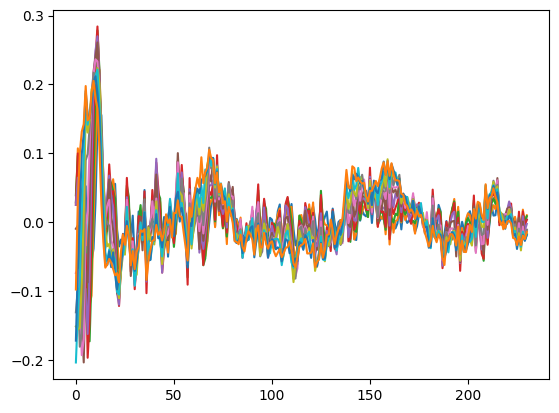

In [66]:
plt.plot(v_H_perp.T)

In [44]:
Y_H_perp.shape

(12, 231)

In [49]:
Gov_Spending_IRF.shape

(21,)

In [59]:
Gov_Spending_IRF.reshape(12,1) @ Z_perp.reshape(1, 231)

array([[ 0.01116998, -0.02879631, -0.0379228 , ..., -0.00687378,
        -0.003382  , -0.00588384],
       [ 0.01474196, -0.03800492, -0.05004992, ..., -0.00907191,
        -0.00446351, -0.0077654 ],
       [ 0.01657465, -0.04272961, -0.05627202, ..., -0.01019971,
        -0.00501841, -0.00873078],
       ...,
       [ 0.00960296, -0.02475652, -0.03260267, ..., -0.00590947,
        -0.00290755, -0.00505841],
       [ 0.00821149, -0.02116929, -0.02787853, ..., -0.00505319,
        -0.00248624, -0.00432544],
       [ 0.00695672, -0.01793448, -0.02361851, ..., -0.00428103,
        -0.00210633, -0.00366449]], shape=(12, 231))

In [55]:
Gov_Spending_IRF.shape

(12,)

In [56]:
Z_perp.shape

(231,)

In [40]:
Gov_Spending_IRF

array([0.01354778, 0.01788016, 0.02010298, 0.02116556, 0.02074534,
       0.01939896, 0.01751513, 0.01547931, 0.01350284, 0.01164719,
       0.00995951, 0.00843763, 0.00708088, 0.00586169, 0.0047702 ,
       0.00380188, 0.00294657, 0.00219972, 0.00155515, 0.0010056 ,
       0.000544  ])

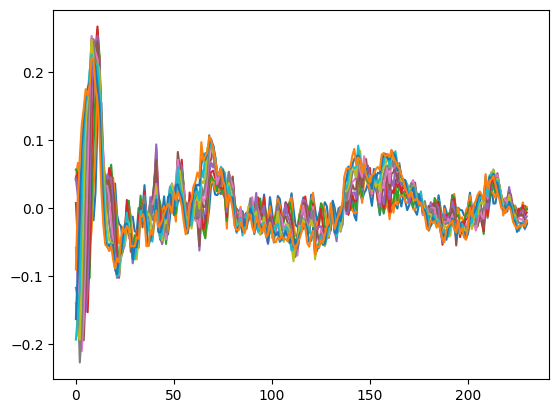

In [113]:
plt.plot(Y_H_perp.T)

In [68]:
X_H - X_H_fcst

array([[-0.09535724, -0.08629892, -0.11412967, ..., -0.00363891,
        -0.00233502, -0.00778674],
       [-0.06004341, -0.0621085 , -0.08103809, ...,  0.00207082,
        -0.00156136, -0.00086905],
       [-0.06083216, -0.07263739, -0.06560905, ...,  0.00308351,
         0.00224133,  0.00246993],
       ...,
       [-0.71452684, -0.70098826, -0.70246451, ..., -0.00698165,
        -0.01227001, -0.02501933],
       [-0.75365816, -0.7549345 , -0.74808392, ..., -0.05002709,
        -0.04885119, -0.04820271],
       [-0.13683271, -0.11854678, -0.11518892, ...,  0.01163567,
         0.01426248,  0.01513684]], shape=(84, 231))

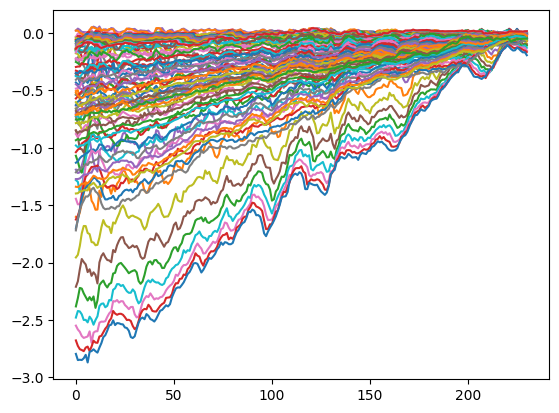

In [67]:
plt.plot((X_H-X_H_fcst).T)

In [63]:
X_H - X_H_fcst

array([[-0.09535724, -0.08629892, -0.11412967, ..., -0.00363891,
        -0.00233502, -0.00778674],
       [-0.06004341, -0.0621085 , -0.08103809, ...,  0.00207082,
        -0.00156136, -0.00086905],
       [-0.06083216, -0.07263739, -0.06560905, ...,  0.00308351,
         0.00224133,  0.00246993],
       ...,
       [-0.71452684, -0.70098826, -0.70246451, ..., -0.00698165,
        -0.01227001, -0.02501933],
       [-0.75365816, -0.7549345 , -0.74808392, ..., -0.05002709,
        -0.04885119, -0.04820271],
       [-0.13683271, -0.11854678, -0.11518892, ...,  0.01163567,
         0.01426248,  0.01513684]], shape=(84, 231))

In [27]:
govdat[vars_for_var].to_numpy()

array([[-9.02970559, -9.23305678, -9.16034015, ..., -7.07137405,
        -1.07579234,  0.238     ],
       [-9.0281414 , -9.23931444, -9.14961097, ..., -7.08189431,
        -1.06596109,  0.238     ],
       [-9.02338199, -9.24450763, -9.15232544, ..., -7.07845518,
        -1.08341268,  0.238     ],
       ...,
       [-7.96342234, -7.95997779, -7.96489578, ..., -7.05775294,
         0.31157939,  0.35299999],
       [-7.95402604, -7.96914404, -7.97349312, ..., -7.06764104,
         0.31195691,  0.35299999],
       [-7.95368053, -7.98550075, -7.97819656, ..., -7.08543964,
         0.32084492,  0.35299999]], shape=(248, 7))

In [ ]:
# Now for the Ramey-Shapiro method with military shock dates (assuming 'wara' is the military shock)
# Assuming you have a variable 'wara' indicating military shock periods

# Augment the VAR with the military shock dates variable
vars_for_var_ramey = [
    "wara",
    "lrgov",
    "lrgdp",
    "lrcndsv",
    "lrinvfx",
    "ltothoursces",
    "lrwbus",
    "amtbr",
]

# Create the VAR model for Ramey-Shapiro method
model_ramey = VAR(govdat[vars_for_var_ramey])
var_result_ramey = model_ramey.fit(lag_order)

# Get the impulse response function (IRF) for military shock
irf_ramey = var_result_ramey.irf(20)

# Plot the IRF for military shock
irf_ramey.plot(impulse="wara", signif=0.68)
plt.show()